In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datadir = '/home/pdcg/Documents/post_process_routines/'
gsl_solver = 'lvl5_pmtensor/'
s = pynbody.load(datadir+gsl_solver+'snapdir_127/snapshot_127')

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/snapshot/gadgethdf.py:370: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [3]:
G = 6.674e-8 # In cgs cm3 s-2 g-1
kpc = 3.09e21 # in cm
msun = 1.989e33 # in g
gyr = 3.15576e16 # in s
s['eps'] = s['smooth']
for key in s.families():
  s[key]['eps'] = s[key]['eps'].min()
s.physical_units()

In [4]:
h = s.halos()
h1_tf = pynbody.analysis.angmom.faceon(h[1])

In [5]:
s['Tij'] = s['TIJ_Eigenvalues'] * gyr**2
s['T'] = s['Tij_x'] + 1/3*np.abs(s['Tij_x'] + s['Tij_y'] + s['Tij_z'])

In [27]:
p = pynbody.analysis.profile.Profile(h[1].d, min=0.01, max= 50, ndim=3)

In [34]:
mask = (h[1].s['age'].in_units('Gyr')<2) * (h[1].s['InitialMassFractionInClusters']>0.)

In [35]:
circ_vel_est = np.sqrt(1/3 * np.abs(h[1].s['Tij_x'] + h[1].s['Tij_y'] + h[1].s['Tij_z']))
kappa_est = np.sqrt(3*circ_vel_est**2 - h[1].s['Tij_x'])

/tmp/ipykernel_73190/3310437130.py:2: RuntimeWarning: invalid value encountered in sqrt
  kappa_est = np.sqrt(3*circ_vel_est**2 - h[1].s['Tij_x'])


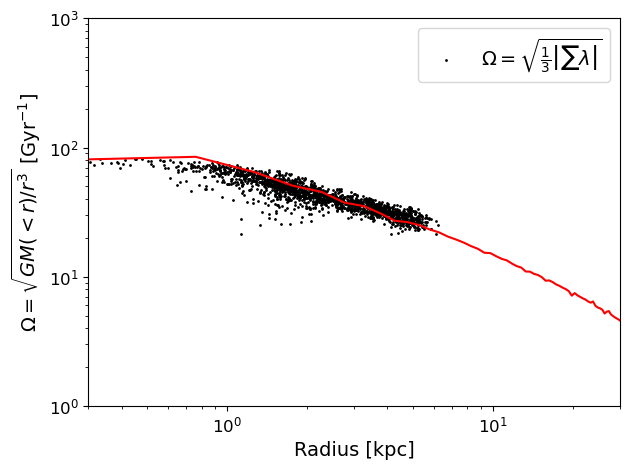

In [36]:
plt.loglog(p['rbins'], p['omega'], c='r')
plt.scatter(h[1].s['r'][mask], circ_vel_est[mask], s=1, c='k', label=r'$\Omega = \sqrt{\frac{1}{3}\left| \sum{\lambda}\right|}$')
plt.xlim(3e-1, 3e1)
plt.ylim(1e0, 1e3)
plt.legend(fontsize=14)
plt.xlabel("Radius [kpc]", fontsize=14)
plt.ylabel(r"$\Omega = \sqrt{GM(<r)/r^3}$ [Gyr$^{-1}$]", fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('circvel_tidal.png')

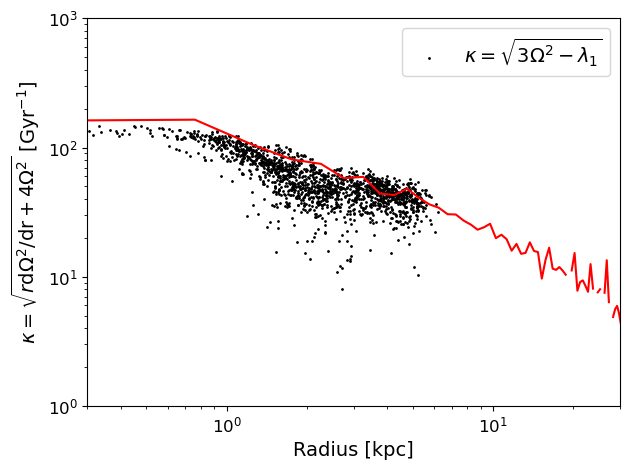

In [37]:
plt.scatter(h[1].s['r'][mask], kappa_est[mask], s=1, c='k', label=r'$\kappa = \sqrt{3\Omega^2 - \lambda_1}$')
plt.loglog(p['rbins'], p['kappa'], c='r')
plt.xlim(3e-1,3e1)
plt.ylim(1e0,1e3)
plt.legend(fontsize=14)
plt.xlabel("Radius [kpc]", fontsize=14)
plt.ylabel(r"$\kappa = \sqrt{r \rm{d}\Omega^2/\rm{d}r + 4\Omega^2}$ [Gyr$^{-1}$]", fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('epyciclic_tidal.png')

In [32]:
dens_prof_est = np.abs(h[1].s['Tij_x'] + h[1].s['Tij_y'] + h[1].s['Tij_z'])/(4 * np.pi * G * gyr**2)
dens_prof_est *= (kpc**3)/(msun)

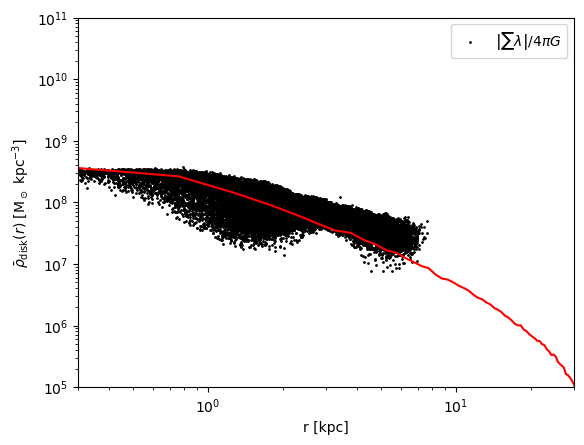

In [33]:
plt.plot(p['rbins'], p['density'], c='r')
plt.scatter(h[1].s['r'], dens_prof_est, s=1, c='k', label=r'$\left| \sum{\lambda}\right| / 4 \pi G$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e5, 1e11)
plt.xlim(3e-1, 3e1)
plt.xlabel("r [kpc]")
plt.ylabel(r"$\bar{\rho}_\mathrm{disk} (r)$ [M$_\odot$ kpc$^{-3}$]")
plt.legend()
# plt.savefig('avedens_tidal.png')

In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
datadir = '/home/pdcg/Documents/post_process_routines/'
pmtensor = 'lvl5_pmtensor/'
treetensor = 'lvl5_treetensor/'
s0 = pynbody.load(datadir+pmtensor+'snapdir_024/snapshot_024')
s1 = pynbody.load(datadir+treetensor+'snapdir_024/snapshot_024')

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [3]:
s0.properties['Redshift']

14.763496016419264

In [4]:
for s in (s0,s1):
    s['eps'] = s['smooth']
    for key in s.families():
        s[key]['eps'] = s[key]['eps'].min()

In [5]:
h0 = s0.halos()
t0 = pynbody.analysis.angmom.faceon(h0[0])
h1 = s1.halos()
t1 = pynbody.analysis.angmom.faceon(h1[0])

s0.physical_units()
s1.physical_units()

In [6]:
# s0['pos'] -= s0.properties['boxsize']/2.
# s1['pos'] -= s1.properties['boxsize']/2.

In [7]:
gyr = 3.15576e16 # in s
s0['TidalTensor'] *= gyr**2
s0['TidalTensorPM'] *= gyr**2
s1['TidalTensor'] *= gyr**2

In [8]:
s0['TidalTensorTotal'] = s0['TidalTensor'] + s0['TidalTensorPM']

In [14]:
s0['Tij'] = np.sort(np.linalg.eigvalsh((s0['TidalTensor']).reshape(len(s0),3,3)), axis=1)
s0['Tij_pm'] = np.sort(np.linalg.eigvalsh((s0['TidalTensorPM']).reshape(len(s0),3,3)), axis=1)
s0['Tij_total'] = np.sort(np.linalg.eigvalsh((s0['TidalTensorTotal']).reshape(len(s0),3,3)), axis=1)
s1['Tij'] = np.sort(np.linalg.eigvalsh((s1['TidalTensor']).reshape(len(s1),3,3)), axis=1)

s0['T'] = s0['Tij'][:,2] - 1./2. * (s0['Tij'][:,0] + s0['Tij'][:,1])
s0['T_pm'] = s0['Tij_pm'][:,2] - 1./2. * (s0['Tij_pm'][:,0] + s0['Tij_pm'][:,1])
s0['T_total'] = s0['Tij_total'][:,2] - 1./2. * (s0['Tij_total'][:,0] + s0['Tij_total'][:,1])
s1['T'] = s1['Tij'][:,2] - 1./2. * (s1['Tij'][:,0] + s1['Tij'][:,1])

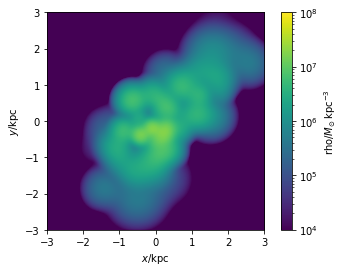

In [10]:
pynbody.plot.sph.image(h0[0].g, width=6, show_cbar=True, weight=False, log=True, vmin=1e4, vmax=1e8)

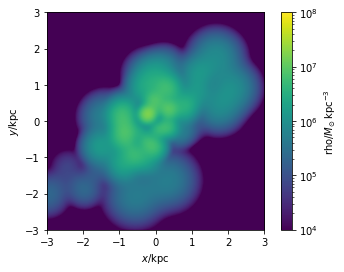

In [11]:
pynbody.plot.sph.image(h1[0].g, width=6, show_cbar=True, weight=False, log=True, vmin=1e4, vmax=1e8)

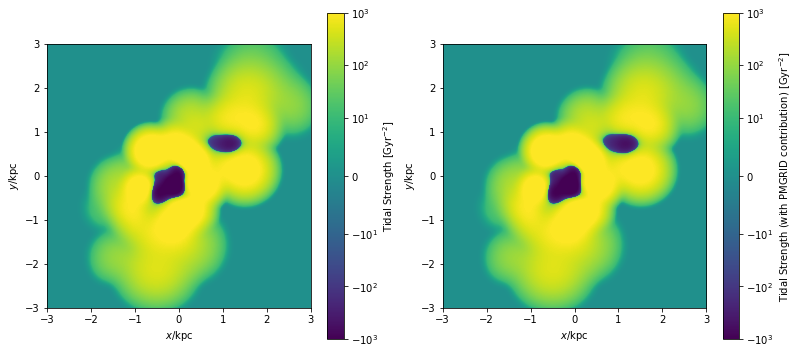

In [43]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
im0 = pynbody.plot.sph.image(h0[0].g, qty='Tij_z', width=6, show_cbar=False, weight=False, log=True, vmin=-1e3, vmax=1e3, axes=ax[0], linthresh=1e1, return_image=True)
fig.colorbar(im0, ax=ax[0], label='Tidal Strength [Gyr$^{-2}$]')
im1 = pynbody.plot.sph.image(h0[0].g, qty='Tij_total_z', width=6, show_cbar=False, weight=False, log=True, vmin=-1e3, vmax=1e3, axes=ax[1], linthresh=1e1, return_image=True)
fig.colorbar(im1, ax=ax[1], label='Tidal Strength (with PMGRID contribution) [Gyr$^{-2}$]')
plt.savefig('tidal_strength_comparisson.pdf')

In [25]:
p0 = pynbody.analysis.profile.Profile(h0[0].g, min=0, max=3.5, ndim=3, nbins=20)
p1 = pynbody.analysis.profile.Profile(h1[0].g, min=0, max=3.5, ndim=3, nbins=20)

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/analysis/profile.py:380: RuntimeWarning: invalid value encountered in scalar divide
  result[i] = (name_array * mass_array).sum() / self['weight_fn'][i]
/home/pdcg/.local/lib/python3.10/site-packages/pynbody/analysis/profile.py:380: RuntimeWarning: invalid value encountered in scalar divide
  result[i] = (name_array * mass_array).sum() / self['weight_fn'][i]


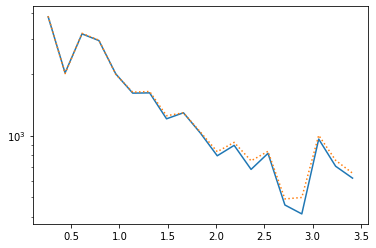

In [26]:
plt.plot(p0['rbins'], p0['T'])
plt.plot(p0['rbins'], p0['T_total'], ':')
plt.yscale('log')
# plt.plot(p1['rbins'], p1['pot'], ':')